In [1]:
import numpy as np
import pandas as pd 

import os
import json

import tensorflow as tf

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading

In [2]:
## path to directories
transcript_path = "../input/harpervalleydataset-transcript-only/HarperValleyDataset_transcript/HarperValley_transcript/"
metadata_path = "../input/harpervalleydataset-transcript-only/HarperValleyDataset_metadata/metadata/"

## Reading the transcripts

In [3]:
all_trans = list()
for file in os.listdir(transcript_path):
    filename = "%s%s" % (transcript_path, file)
    with open(filename, 'r') as fi:
        js_text = json.load(fi)
        h_trans = [item["speaker_role"] + " " + item["human_transcript"] for item in js_text]
        str_trans = ' '.join(str(item) for item in h_trans)
        all_trans.append(str_trans)

In [4]:
# print(type(all_trans))
# print(len(all_trans))
# # print(all_trans[:1])
df_x = pd.DataFrame(all_trans, columns = ["transcript"])
# df_x.tail()

## Reading the labels

In [5]:
all_labels = list()
for file in os.listdir(metadata_path):
    filename = "%s%s" % (metadata_path, file)
    with open(filename, 'r') as fi:
        js_text = json.load(fi)
        task = js_text["tasks"][0]["task_type"]
        all_labels.append(task)

In [6]:
df_y = pd.DataFrame(all_labels, columns = ["tasks"])
df_y.tail()

,tasks
995,check balance
996,order checks
997,order checks
998,order checks
999,check balance


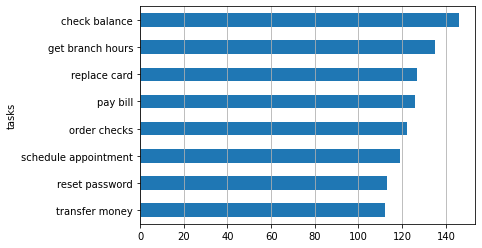

In [7]:
x = "tasks"
fig, ax = plt.subplots()
# fig.suptitle(x, fontsize=12)
df_y[x].reset_index().groupby(x).count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.savefig("task_distribution.png", bbox_inches='tight')
plt.show()

In [8]:
df = pd.concat([df_x, df_y], axis=1)
df.tail()

,transcript,tasks
995,agent hello this is harper valley national ban...,check balance
996,agent hello this is harper valley national ban...,order checks
997,agent hello agent this is harper valley nation...,order checks
998,agent hello this is agent hello this is harper...,order checks
999,agent [noise] agent hello this is harper valle...,check balance


# Data Preprocessing

In [9]:
max_seq = 40
max_vocab_size = 5000

In [10]:
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(df['transcript'])
sequences = tokenizer.texts_to_sequences(df['transcript'])
word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index), type(word_index))

Found 663 unique tokens. <class 'dict'>


In [11]:
data = pad_sequences(sequences, maxlen=430, padding='post')
encoded_dict = {"check balance":0, "get branch hours":1, "replace card":2, "pay bill":3, "order checks":4, "schedule appointment":5, "reset password":6, "transfer money":7}
df['tasks_cat'] = df.tasks.map(encoded_dict)
labels = to_categorical(df.tasks_cat)
print("shape of data tensor:", data.shape, type(data))
print("shape of label tensor:", labels.shape, type(labels))

shape of data tensor: (1000, 430) <class 'numpy.ndarray'>
shape of label tensor: (1000, 8) <class 'numpy.ndarray'>


In [12]:
# data_sliced = data[:, 15:55]
data_sliced = data

In [13]:
print(data_sliced.shape)

(1000, 430)


## Splitting into training and test data

In [14]:
X_train_val, X_test, y_train_val, y_test = train_test_split(data_sliced, labels, test_size=0.15, random_state=1)

In [15]:
print(X_train_val.shape)

(850, 430)


## Validation data

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=1)

In [17]:
print(X_train.shape, X_val.shape)

(680, 430) (170, 430)


# Model

In [18]:
from keras.layers import Dense, Input, GlobalMaxPool1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten
from keras.models import Model, Sequential
from keras.initializers import Constant

In [19]:
embedding_dim = 60
num_words = min(max_vocab_size, len(word_index)+1)
embedding_layer = Embedding(num_words, embedding_dim, input_length=max_seq, trainable=True)

In [20]:
sequence_input = Input(shape=(430,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(64, 5, activation='relu')(embedded_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(64, 5, activation='relu')(x)
x = Conv1D(64, 5, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
preds = Dense(8, activation='softmax')(x)
model = Model(inputs=sequence_input, outputs=preds)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

2022-04-15 10:26:13.886230: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 430)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 430, 60)           39840     
_________________________________________________________________
conv1d (Conv1D)              (None, 426, 64)           19264     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 422, 64)           20544     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 211, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 207, 64)           20544     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 203, 64)           20544 

In [21]:
model_table=pd.DataFrame(columns=["Type","Shape", "Param #"])
for layer in model.layers:
    model_table = model_table.append({"Type": layer.__class__.__name__,"Shape":layer.output_shape, "Param #":layer.count_params()}, ignore_index=True)

In [22]:
model_table.head()
print(model_table.to_latex(index=False))

\begin{tabular}{lll}
\toprule
        Type &           Shape & Param \# \\
\midrule
  InputLayer &   [(None, 430)] &       0 \\
   Embedding & (None, 430, 60) &   39840 \\
      Conv1D & (None, 426, 64) &   19264 \\
      Conv1D & (None, 422, 64) &   20544 \\
MaxPooling1D & (None, 211, 64) &       0 \\
      Conv1D & (None, 207, 64) &   20544 \\
      Conv1D & (None, 203, 64) &   20544 \\
MaxPooling1D & (None, 101, 64) &       0 \\
      Conv1D & (None, 99, 128) &   24704 \\
      Conv1D & (None, 97, 128) &   49280 \\
MaxPooling1D & (None, 48, 128) &       0 \\
     Flatten &    (None, 6144) &       0 \\
       Dense &     (None, 100) &  614500 \\
       Dense &     (None, 100) &   10100 \\
       Dense &       (None, 8) &     808 \\
\bottomrule
\end{tabular}



In [23]:
print(X_train.shape)

(680, 430)


In [24]:
# for i in range(1, 5):
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
asd = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), verbose=1, callbacks=callback)
tr_scr = model.evaluate(X_train, y_train, verbose=0)
score = model.evaluate(X_val, y_val, verbose=1)

2022-04-15 10:26:14.626200: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
22/22 [==============================] - 5s 148ms/step - loss: 2.0787 - acc: 0.1250 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.0639 - val_acc: 0.1176 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
22/22 [==============================] - 3s 137ms/step - loss: 1.6500 - acc: 0.3515 - precision: 0.6016 - recall: 0.1088 - val_loss: 1.1885 - val_acc: 0.5588 - val_precision: 0.7111 - val_recall: 0.3765
Epoch 3/30
22/22 [==============================] - 2s 103ms/step - loss: 0.9260 - acc: 0.6412 - precision: 0.7651 - recall: 0.5029 - val_loss: 1.0031 - val_acc: 0.6353 - val_precision: 0.8365 - val_recall: 0.5118
Epoch 4/30
22/22 [==============================] - 2s 103ms/step - loss: 0.6353 - acc: 0.7647 - precision: 0.8506 - recall: 0.6779 - val_loss: 0.8762 - val_acc: 0.7176 - val_precision: 0.7284 - val_recall: 0.6941
Epoch 5/30
22/22 [==============================] - 2s 105ms/step - loss: 0.3897 - acc: 0.8662 - precision: 0.8961 - recall: 0.8

In [25]:
# asd.history

# Evaluation

In [26]:
val_recall = asd.history["val_recall"]
val_precision = asd.history['val_precision']
val_acc = asd.history['val_acc']
val_loss = asd.history['val_loss']

In [27]:
acc_tr = asd.history['acc']
loss_tr = asd.history['loss']

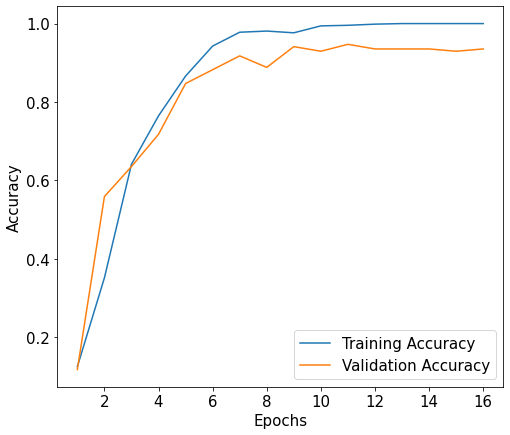

In [28]:
plt.figure(figsize=(8,7))
plt.rc("font", size=15)
plt.plot(range(1,len(acc_tr)+1), acc_tr, label="Training Accuracy")
plt.plot(range(1,len(acc_tr)+1), val_acc, label="Validation Accuracy")
# plt.xlim([0,31])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("Accuracy_vs_epochs")
plt.show()

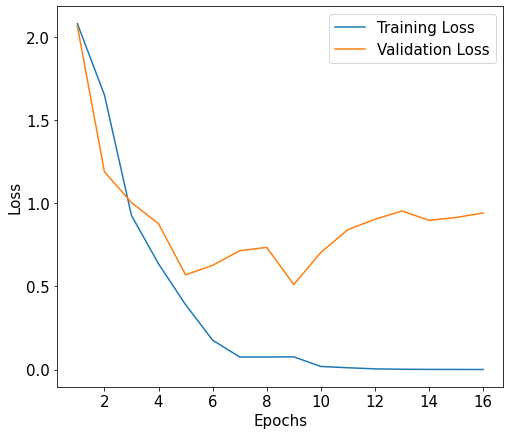

In [29]:
plt.figure(figsize=(8,7))
plt.rc("font", size=15)
plt.plot(range(1,len(loss_tr)+1), loss_tr, label="Training Loss")
plt.plot(range(1,len(loss_tr)+1), val_loss, label="Validation Loss")
# plt.xlim([0,31])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("Loss_vs_epochs.eps")
plt.show()

## Test set evaluation

In [30]:
test_score = model.evaluate(X_test, y_test, verbose=1)
print(test_score)

5/5 [==============================] - 0s 25ms/step - loss: 0.8025 - acc: 0.9467 - precision: 0.9467 - recall: 0.9467
[0.8025168776512146, 0.9466666579246521, 0.9466666579246521, 0.9466666579246521]
